In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import from_contents, plot

from missense_kinase_toolkit.databases import (
    cbioportal, 
    hgnc, 
    kinase_schema,
)

from missense_kinase_toolkit.databases.utils import (
    create_strsplit_list,
    return_list_out,
    try_except_match_str2dict,
    replace_string_using_dict,
    try_except_convert_str2int,
)

from missense_kinase_toolkit.databases import (
    uniprot,
    pfam,
)

from missense_kinase_toolkit.databases.colors import DICT_COLORS
from missense_kinase_toolkit.databases.plot import SequenceAlignment

# Load data

In [3]:
df_pkis = pd.read_excel("../data/3. PKIS Nanosyn Assay Heatmaps.xlsx",
                        sheet_name="Assay and Panel information")

df_kinhub = pd.read_csv("../data/kinhub.csv")
df_uniprot = pd.read_csv("../data/kinhub_uniprot.csv")
# not currently in use
# df_klifs = pd.read_csv("../data/kinhub_klifs.csv")
df_pfam = pd.read_csv("../data/kinhub_pfam.csv")

# Extract $K_{M, ATP}$ from PKIS2 data

In [4]:
df_uniprot_kinhub = df_uniprot.merge(df_kinhub, 
                                     left_on="uniprot_id", 
                                     right_on="UniprotID", 
                                     how="left")
df_pkis_copy = df_pkis.copy()

In [5]:
list_mut = [
    "ABL1-H396P",
    "ABL1-M351T",
    "ABL1-Q252H",
    "ABL1-T315I",
    "ABL1-Y253F",
    "BRAF-V599E",
    "EGFR-L858R",
    "EGFR-L861Q",
    "EGFR-T790M",
    "EGFR-T790M-L858R",
    "FLT-3-D835Y",
    "KIT-D816V",
    "KIT-T6701",
    "KIT-V560G",
    "LRRK2-G2019S",
    "PDGFR-ALPHA-D842V",
    "PDGFR-ALPHA-T674I",
    "PDGFR-ALPHA-V561D",
    "RET-V804L",
    "RET-Y791F",
]

In [6]:
# drop lipid kinases and those whose identities we can't resolve
list_drop = [
    "PI3-KINASE-ALPHA", # lipid kinase
    "PI3-KINASE-DELTA", # lipid kinase
    "PI3-KINASE-GAMMA", # lipid kinase
    "PI4-K-BETA",       # lipid kinase
    "SPHK1",            # lipid kinase
    "SPHK2",            # lipid kinase
    "AMP-A1B1G1",       # B1G1 subunits not kinase entries
    "AMP-A2B1G1",       # B1G1 subunits not kinase entries
    "CK2",              # not sure if CSNK2A1 or CSNK2A2; catalog not available
    "CDK2-CYCLINE",     # complexed with cycline - cannot account for
    "PKCB",             # not sure how this differs from PKC-BETA1
    "TRKB-L",           # not sure how this differs from TRKB
    "PKD2",             # cannot tell difference between PRKD2 using UniProt ID
]

df_pkis_copy = df_pkis_copy.loc[~df_pkis_copy["Assay Name"].isin(list_drop), ].reset_index(drop=True)

# two minor manual adjustments causing issues
df_pkis_copy.loc[df_pkis_copy["Assay Name"].apply(lambda x: x == "EGFR-002"), "Assay Name"] = "EGFR"
df_pkis_copy["Assay Name"] = df_pkis_copy["Assay Name"].apply(lambda x: x.replace("ABL-", "ABL1-"))

list_assay_set = create_strsplit_list(df_pkis_copy["Assay Name"].tolist())

list_hgnc = df_uniprot_kinhub["hgnc_name"].tolist()
list_xname = df_uniprot_kinhub["xName"].apply(lambda x: x.split(", ")).tolist()
list_manning = df_uniprot_kinhub["Manning Name"].apply(lambda x: x.split(", ")).tolist()
list_combo = [[x] + y + z for x, y, z in zip(list_hgnc, list_xname, list_manning)]

# check if assay set in HGNC name, xName, or Manning Name
list_out, set_out = return_list_out(list_combo, list_assay_set)

# [f"{df_pkis_copy.assay_set.iloc[idx]}: {i}" for idx, i in enumerate(list(set_out)) if len(i) > 1]

dict_exact = {
    "ARK5"         : "NUAK1",
    "CK1"          : "CK1a",
    "CRAF"         : "RAF1",
    "LRRK"         : "LRRK2",
    "LYNA"         : "LYN",
    "MEK1"         : "MAP2K1",
    "P70S6K1"      : "RPS6KB1",
    "PKA"          : "PKACa",
    "PAR-1B-ALPHA" : "MARK2",
    "PKC-BETA1"    : "PKC-B",
    "PRAK"         : "MAPKAPK5",
    "PTK5"         : "FRK",
    "SNF1LK2"      : "QIK"
}

dict_partial = {
    "AURORA"  : "AURK",
    "ALPHA"   : "A",
    "BETA"    : "B",
    "DELTA"   : "D",
    "EPSILON" : "E",
    "GAMMA"   : "G",
    "-ETA"    : "H",
    "IOTA"    : "I",
    "THETA"   : "T"
}

list_idx_nan = [idx for idx, i in enumerate(list_out) if i is np.nan]
list_name_nan = [i  if idx in list_idx_nan else np.nan for idx, i in enumerate(df_pkis_copy["Assay Name"])]
list_nan_rep1 = [try_except_match_str2dict(x, dict_exact) for x in list_name_nan]
list_nan_rep2 = [replace_string_using_dict(x, dict_partial) for x in list_nan_rep1]

list_assay_nan = create_strsplit_list(list_nan_rep2)
list_out_nan, set_out_nan = return_list_out(list_combo, list_assay_nan)
# [f"{df_pkis_copy['Assay Name'].iloc[idx]}: {i}" for idx, i in enumerate(list(set_out_nan)) if len(i) > 1]
list_out_nan, set_out_nan = return_list_out(list_combo, list_assay_nan)

list_concat = [i if i is not np.nan else j for i, j in zip(list_out, list_out_nan)]
# [f"{df_pkis_copy['Assay Name'].iloc[idx]}: {i}" for idx, i in enumerate(list(list_concat)) if i is np.nan]

df_pkis_copy["uniprot"] = [df_uniprot_kinhub["uniprot_id"].iloc[idx] \
                           if idx is not np.nan else np.nan for idx in list_concat]

# manual fix
# df_pkis_copy.loc[df_pkis_copy["Assay Name"] == "PKD2", "uniprot"] = "Q13563"
df_pkis_copy.loc[df_pkis_copy["Assay Name"] == "PRKD2", "uniprot"] = "Q9BZL6"
df_pkis_copy.loc[df_pkis_copy["Assay Name"] == "RSK1", "uniprot"] = "Q15418"

In [7]:
str_manual = "P07948-2"

# duplicate LYN and change UniProtID to P07948-2
# df_temp = df_kinhub.loc[df_kinhub["HGNC Name"] == "LYN", ].reset_index(drop=True)
# df_temp["UniprotID"] = str_manual
# df_kinhub = pd.concat([df_kinhub, df_temp], axis=0).reset_index(drop=True)

# manually replace LYNB in df_pkis_copy
df_pkis_copy.loc[df_pkis_copy["uniprot"].isna(), "uniprot"] = str_manual

In [8]:
df_pkis_copy["Mutant"] = False
df_pkis_copy.loc[df_pkis_copy["Assay Name"].isin(list_mut), "Mutant"] = True

In [9]:
df_pkis_wt = df_pkis_copy.loc[~df_pkis_copy["Assay Name"].isin(list_mut), ].reset_index(drop=True)
df_pkis_wt = df_pkis_wt.loc[~(
    df_pkis_wt["uniprot"] == str_manual), ].reset_index(drop=True)

In [10]:
dict_kinase = kinase_schema.create_kinase_models_from_df()

dict_kinase_wt = {j.uniprot_id: j for j in dict_kinase.values() if j.uniprot_id in df_pkis_wt["uniprot"].tolist()}

dict_kinase_wt_narm = {i: j for i, j in dict_kinase_wt.items() if j.KLIFS.pocket_seq is not None}

dict_aligned = kinase_schema.align_inter_intra_region(dict_kinase_wt_narm)
dict_replace = kinase_schema.reverse_order_dict_of_dict(dict_aligned)

for key in dict_kinase_wt_narm.keys():
    dict_kinase_wt[key].KLIFS2UniProtSeq.update(dict_replace[key])

In [11]:
list_uniprot = []
list_kincore = []
list_klifs_min = []
list_klifs_full = []
list_group = []

for _, row in df_pkis_wt.iterrows():
    uniprot_id = row["uniprot"]
    if uniprot_id not in dict_kinase_wt.keys():
        print(uniprot_id)
    else:
        temp_obj = dict_kinase_wt[uniprot_id]
        list_uniprot.append(temp_obj.UniProt.canonical_seq)
        if temp_obj.KinCore is None:
            list_kincore.append(None)
        else:
            list_kincore.append(temp_obj.KinCore.seq)
        list_klifs_min.append(temp_obj.KLIFS.pocket_seq)
        if temp_obj.KLIFS.pocket_seq is None:
            list_klifs_full.append(None)
        else:
            list_klifs_full.append("".join([i for i in temp_obj.KLIFS2UniProtSeq.values()\
                                            if i is not None]))

        list_group.append([i.value for i in temp_obj.KinHub.group][0])

df_pkis_wt["group"] = list_group
df_pkis_wt["seq_uniprot"] = list_uniprot
df_pkis_wt["seq_kincore"] = list_kincore
df_pkis_wt["seq_klifs_min"] = list_klifs_min
df_pkis_wt["seq_klifs_full"] = list_klifs_full

# uncomment to overwrite
# df_pkis_wt.to_csv("../data/pkis2_km_atp.csv", index=False)

In [ ]:
#TODO: "P07948-2" and mutants
#NOT IN USE

# # extract kinase domain entries only in Pfam
# list_uniprot = df_pkis_copy.loc[~df_pkis_copy["uniprot"].isna(), "uniprot"].tolist()
# list_kd = ["Protein kinase domain", 
#            "Protein tyrosine and serine/threonine kinase"]
# df_pfam_kd = df_pfam.loc[((df_pfam["name"].isin(list_kd)) & \
#                           (df_pfam["uniprot"].isin(list_uniprot))), ["uniprot", "name", "start", "end"]]

# # merge to add UniProt, Pfam, and KinHub annotations
# df_pkis_copy = df_pkis_copy.merge(df_uniprot, how="left", left_on="uniprot", right_on="uniprot_id")
# df_pkis_copy = df_pkis_copy.drop(columns=["uniprot_id"])
# df_pkis_copy = df_pkis_copy.merge(df_pfam_kd, how="left", left_on="uniprot", right_on="uniprot")
# df_pkis_copy = df_pkis_copy.merge(df_kinhub, how="left", left_on="uniprot", right_on="UniprotID")
# df_pkis_copy = df_pkis_copy.drop(columns=["UniprotID"])

# # add canonical UniProt sequence
# df_pkis_copy.loc[df_pkis_copy["uniprot"] == "P07948-2", "canonical_sequence"] = uniprot.UniProt(str_manual)._sequence
# # added manually as InterPro API doesn"t have isoform functionality
# # https://www.ebi.ac.uk/interpro/protein/reviewed/P07948/?isoform=P07948-2
# df_pkis_copy.loc[df_pkis_copy["uniprot"] == "P07948-2", "start"] = 226
# df_pkis_copy.loc[df_pkis_copy["uniprot"] == "P07948-2", "end"] = 480
# # df_pkis_copy.loc[df_pkis_copy["uniprot"] == "P07948-2", ]

# # extract kinase domain sequence
# # PDK1 has no Pfam KD
# df_pkis_copy["kd"] = [row["canonical_sequence"][int(row["start"])-1:int(row["end"])-1] \
#                       for idx, row in df_pkis_copy.iterrows()]

# Plotting MSAs for representations

In [13]:
list_hgnc = df_pkis_wt["Assay Name"].tolist()
dict_alphabet = DICT_COLORS["ALPHABET_PROJECT"]["DICT_COLORS"]

In [14]:
alignment_klifs_min = SequenceAlignment(
    list_sequences=list_klifs_min,
    list_ids=list_hgnc,
    dict_colors=dict_alphabet
)

alignment_klifs_min.show_plot()

In [15]:
alignment_klifs_full = SequenceAlignment(
    list_sequences=list_klifs_full,
    list_ids=list_hgnc,
    dict_colors=dict_alphabet
)

alignment_klifs_full.show_plot()

# Analyze cBioPortal data

In [30]:
dict_kinase = kinase_schema.create_kinase_models_from_df()

dict_klifs = {i: j for i, j in dict_kinase.items() if \
              (j.KLIFS is not None and j.KLIFS.pocket_seq is not None)}

dict_aligned = kinase_schema.align_inter_intra_region(dict_klifs)
dict_replace = kinase_schema.reverse_order_dict_of_dict(dict_aligned)

for key in dict_klifs.keys():
    dict_klifs[key].KLIFS2UniProtSeq.update(dict_replace[key])

In [101]:
os.environ["CBIOPORTAL_INSTANCE"] = "www.cbioportal.org"
os.environ["OUTPUT_DIR"] = "."
study = "msk_impact_2017"

df_mskimpact_muts = cbioportal.Mutations(study_id=study).get_cbioportal_cohort_mutations()

No API token provided


In [54]:
dict_kinase_wt_hgnc = {j.hgnc_name: j for j in dict_kinase_wt.values() if j.}

In [119]:
df_mskimpact_muts_pkis = df_mskimpact_muts.loc[df_mskimpact_muts["hugoGeneSymbol"].isin(\
    dict_kinase_wt_hgnc.keys()), ].reset_index(drop=True)

In [121]:
df_mskimpact_muts_pkis["residue_idx"] = df_mskimpact_muts_pkis["proteinChange"].apply(try_except_middle_int)

In [117]:
def try_except_middle_int(str_in):
    try:
        return int(str_in[1:-1])
    except ValueError:
        return None

In [133]:
df_mskimpact_muts_missense = df_mskimpact_muts_pkis.loc[((~df_mskimpact_muts_pkis["residue_idx"].isna()) &
                                                         (df_mskimpact_muts_pkis["mutationType"] == "Missense_Mutation")), ].reset_index(drop=True)

In [164]:
from copy import deepcopy

In [181]:
list_temp = []
for _, row in df_mskimpact_muts_missense.iterrows():
    hgnc_name = row["hugoGeneSymbol"]
    temp_obj = dict_kinase_wt_hgnc[hgnc_name]
    list_temp.append(row["residue_idx"] in temp_obj.KLIFS2UniProtIdx.values())
    # idx_min  = min([i for i in temp_obj.KLIFS2UniProtIdx.values() if i is not None])
    # idx_max  = max([i for i in temp_obj.KLIFS2UniProtIdx.values() if i is not None])
    # list_temp.append(idx_min <= row["residue_idx"] <= idx_max)

In [182]:
df_mskimpact_muts_missense_klifs = df_mskimpact_muts_missense.loc[list_temp, ].reset_index(drop=True)

In [183]:
df_mskimpact_muts_missense_klifs.shape

(1201, 39)

In [191]:
str_temp = temp_obj.KLIFS.pocket_seq

In [290]:
len(list_protein_change)

1163

In [291]:
len(set(list_protein_change))

684

In [194]:
list_protein_change = []
list_klifs_mutated = []

for _, row in df_mskimpact_muts_missense_klifs.iterrows():
    temp_obj = dict_kinase_wt_hgnc[row["hugoGeneSymbol"]]
    idx_klifs = [idx for idx, i in enumerate(temp_obj.KLIFS2UniProtIdx.values()) if i == row["proteinPosStart"]][0]
    if temp_obj.KLIFS.pocket_seq[idx_klifs] != row["proteinChange"][0]:
        print(f"{temp_obj.hgnc_name}: {row['proteinChange']}, {temp_obj.KLIFS.pocket_seq[idx_klifs]}")
    else:
        list_protein_change.append(f"{temp_obj.hgnc_name}_{row['proteinChange']}")
        str_mut = temp_obj.KLIFS.pocket_seq[:idx_klifs] + row['proteinChange'][-1] + temp_obj.KLIFS.pocket_seq[idx_klifs + 1:]
        list_klifs_mutated.append(str_mut)

FGFR1: I575T, A
FGFR1: L645V, A
FGFR1: S628F, N
FGFR1: K573N, L
FGFR1: A639D, I
FGFR1: P514L, K
FGFR1: S549L, G
FGFR1: T485N, G
FGFR1: M566I, K
FYN: D321N, L
FYN: G354R, L
FYN: A312V, L
FYN: E332K, V
FYN: R386I, Y
FYN: D321H, L
FYN: V324I, D
NTRK2: V624M, D
NTRK2: V624M, D
NTRK2: A571G, V
NTRK2: I549M, F
NTRK2: K618R, E
NTRK2: D692N, I
NTRK2: R598H, E
NTRK2: S667L, L
NTRK2: S667L, L
NTRK2: Q675H, R
NTRK2: D600N, I
NTRK2: V681I, N
NTRK2: L670M, Q
NTRK2: L670M, Q
NTRK2: Q668L, A
NTRK2: R551Q, K
NTRK2: D627N, K
NTRK2: I554V, L
NTRK2: Q674H, H
NTRK2: I672V, F
NTRK2: N596S, Q
NTRK2: D543Y, E


In [198]:
len(list_protein_change)

1163

In [196]:
dict_muts = dict(zip(list_protein_change, list_klifs_mutated))

In [ ]:
set_hgnc = set([i.split("_")[0] for i in dict_muts.keys()])

for i in set_hgnc:
    dict_muts[i] = dict_kinase_wt_hgnc[i].KLIFS.pocket_seq

In [208]:
df_klifs_mut_wt = pd.DataFrame({"hgnc_name": dict_muts.keys(),
                                "klifs": dict_muts.values()})

In [212]:
df_klifs_mut_wt

,hgnc_name,klifs
0,ABL1_E292D,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKDIKPNLVQLLGVYIITE...
1,ABL1_E282Q,HKLGGGQYGEVYEVAVKTLQFLKEAAVMKEIKPNLVQLLGVYIITE...
2,ABL1_E258A,HKLGGGQYGEVYAVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...
3,ABL1_I313T,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYTITE...
4,ABL1_G254R,HKLGGGQYREVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...
...,...,...
735,NTRK2,RELGEGAFGKVFLVAVKTLDFHREAELLTNLQEHIVKFYGVIMVFE...
736,FGFR3,KPLGEGCFGQVVMVAVKMLDLVSEMEMMKMIGKNIINLLGAYVLVE...
737,STK11,DLLGEGSYGKVKERAVKILNVKKEIQLLRRLRKNVIQLVDVYMVME...
738,MAPK1,SYIGEGAYGMVCSVAIKKIRTLREIKILLRFRENIIGINDIYIVQD...


In [219]:
def try_except_split(str_in, dict_in):
    try:
        return dict_in[str_in.split("_")[0]].uniprot_id + " " + str_in.split("_")[1]
    except:
        return dict_in[str_in.split("_")[0]].uniprot_id

In [220]:
df_klifs_mut_wt["uniprot"] = df_klifs_mut_wt["hgnc_name"].apply(lambda x: try_except_split(x, dict_kinase_wt_hgnc))

In [223]:
df_klifs_mut_wt.to_csv("../data/klifs_zehir_muts.csv", index=False)

In [282]:
df_klifs_mut_wt.head()

,hgnc_name,klifs,uniprot
0,ABL1_E292D,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKDIKPNLVQLLGVYIITE...,P00519 E292D
1,ABL1_E282Q,HKLGGGQYGEVYEVAVKTLQFLKEAAVMKEIKPNLVQLLGVYIITE...,P00519 E282Q
2,ABL1_E258A,HKLGGGQYGEVYAVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,P00519 E258A
3,ABL1_I313T,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYTITE...,P00519 I313T
4,ABL1_G254R,HKLGGGQYREVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,P00519 G254R


In [287]:
df_klifs_mut_wt_alphamissense = df_klifs_mut_wt.merge(df_alphamissense_temp_single, how="left", left_on="uniprot", right_on="User_input")

In [288]:
df_klifs_mut_wt_alphamissense

,hgnc_name,klifs,uniprot,User_input,alphamissense_score,alphamissense_class
0,ABL1_E292D,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKDIKPNLVQLLGVYIITE...,P00519 E292D,P00519 E292D,0.4217,AMBIGUOUS
1,ABL1_E282Q,HKLGGGQYGEVYEVAVKTLQFLKEAAVMKEIKPNLVQLLGVYIITE...,P00519 E282Q,P00519 E282Q,0.9771,PATHOGENIC
2,ABL1_E258A,HKLGGGQYGEVYAVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,P00519 E258A,P00519 E258A,0.8037,PATHOGENIC
3,ABL1_I313T,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYTITE...,P00519 I313T,P00519 I313T,0.9996,PATHOGENIC
4,ABL1_G254R,HKLGGGQYREVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,P00519 G254R,P00519 G254R,0.9999,PATHOGENIC
...,...,...,...,...,...,...
735,NTRK2,RELGEGAFGKVFLVAVKTLDFHREAELLTNLQEHIVKFYGVIMVFE...,Q16620,NaN,NaN,NaN
736,FGFR3,KPLGEGCFGQVVMVAVKMLDLVSEMEMMKMIGKNIINLLGAYVLVE...,P22607,NaN,NaN,NaN
737,STK11,DLLGEGSYGKVKERAVKILNVKKEIQLLRRLRKNVIQLVDVYMVME...,Q15831,NaN,NaN,NaN
738,MAPK1,SYIGEGAYGMVCSVAIKKIRTLREIKILLRFRENIIGINDIYIVQD...,P28482,NaN,NaN,NaN


In [289]:
df_klifs_mut_wt_alphamissense.to_csv("../data/klifs_zehir_muts_alphamissense.csv", index=False)

In [286]:
df_alphamissense_temp_single

,User_input,alphamissense_score,alphamissense_class
0,O14757 E134D,0.998,PATHOGENIC
1,O14757 G123V,0.4938,AMBIGUOUS
2,O14757 G89R,0.9684,PATHOGENIC
3,O14757 I39T,0.5518,AMBIGUOUS
4,O14757 N59D,0.9282,PATHOGENIC
...,...,...,...
658,Q9Y243 S238L,0.891,PATHOGENIC
659,Q9Y243 S264F,0.3449,AMBIGUOUS
660,Q9Y243 T195S,0.886,PATHOGENIC
661,Q9Y243 T288R,0.9968,PATHOGENIC


In [285]:
df_alphamissense_temp_single["alphamissense_class"].value_counts()

alphamissense_class
PATHOGENIC    542
BENIGN         79
AMBIGUOUS      42
Name: count, dtype: int64

In [77]:
df_alphamissense = pd.read_csv("../data/protvar_alphamissense.csv", on_bad_lines='skip')

In [78]:
[i for i in df_alphamissense.columns if "Alpha" in i]

['AlphaMissense_pathogenicity(class)']

In [238]:
df_klifs_mut_wt.shape

(740, 3)

In [237]:
df_alphamissense.shape

(911, 43)

In [87]:
df_alphamissense_temp = df_alphamissense[["User_input", "AlphaMissense_pathogenicity(class)"]].groupby("User_input").agg(set)

In [93]:
df_alphamissense_temp.loc[(df_alphamissense_temp["AlphaMissense_pathogenicity(class)"].apply(len) > 1), ].index.to_list()

['O14757 E134D',
 'O14757 G89R',
 'O75676 V66L',
 'O96017 G306R',
 'O96017 L348F',
 'O96017 M304I',
 'P00519 E292D',
 'P00519 E329D',
 'P00519 G254R',
 'P00519 Q300H',
 'P00533 G779F',
 'P00533 L747F',
 'P00533 L747P',
 'P00533 V765L',
 'P00533 V834L',
 'P04049 G361R',
 'P04049 G485R',
 'P04626 L755A',
 'P04626 L755P',
 'P04626 V777L',
 'P04629 V658L',
 'P07333 G589R',
 'P07333 G798R',
 'P07333 M617I',
 'P07947 V404L',
 'P07949 E818D',
 'P07949 M868I',
 'P07949 V755L',
 'P08069 D1153E',
 'P08069 F1047L',
 'P08069 M1012I',
 'P08069 S1089R',
 'P08069 V1053L',
 'P08922 E2030L',
 'P08922 G2031R',
 'P09619 G687K',
 'P09619 G687R',
 'P09619 N666K',
 'P10721 L679F',
 'P10721 M651I',
 'P10721 N655K',
 'P10721 N680K',
 'P11309 F132L',
 'P11309 G190R',
 'P11309 R105S',
 'P11309 S97R',
 'P11309 V126L',
 'P11309 V86L',
 'P12931 E323D',
 'P12931 Q312H',
 'P14616 G1132R',
 'P15056 D594E',
 'P15056 F595L',
 'P15056 G464R',
 'P15056 G469R',
 'P15056 G469S',
 'P15056 L597S',
 'P16234 L599F',
 'P16234 N

In [269]:
df_alphamissense_temp_single = df_alphamissense_temp.loc[df_alphamissense_temp["AlphaMissense_pathogenicity(class)"].apply(len) == 1, ].reset_index()

In [270]:
df_alphamissense_temp_single

,User_input,AlphaMissense_pathogenicity(class)
0,O14757 E134D,{0.998(PATHOGENIC)}
1,O14757 G123V,{0.4938(AMBIGUOUS)}
2,O14757 G89R,{0.9684(PATHOGENIC)}
3,O14757 I39T,{0.5518(AMBIGUOUS)}
4,O14757 N59D,{0.9282(PATHOGENIC)}
...,...,...
658,Q9Y243 S238L,{0.891(PATHOGENIC)}
659,Q9Y243 S264F,{0.3449(AMBIGUOUS)}
660,Q9Y243 T195S,{0.886(PATHOGENIC)}
661,Q9Y243 T288R,{0.9968(PATHOGENIC)}


In [272]:
df_alphamissense_temp_single["alphamissense"]

0       0.998(PATHOGENIC)
1       0.4938(AMBIGUOUS)
2      0.9684(PATHOGENIC)
3       0.5518(AMBIGUOUS)
4      0.9282(PATHOGENIC)
              ...        
658     0.891(PATHOGENIC)
659     0.3449(AMBIGUOUS)
660     0.886(PATHOGENIC)
661    0.9968(PATHOGENIC)
662    0.9902(PATHOGENIC)
Name: alphamissense, Length: 663, dtype: object

In [271]:
df_alphamissense_temp_single["alphamissense"] = df_alphamissense_temp_single["AlphaMissense_pathogenicity(class)"].apply(lambda x: next(iter(x)))

In [274]:
df_alphamissense_temp_single = df_alphamissense_temp_single.drop(columns = ["AlphaMissense_pathogenicity(class)"]).reset_index(drop=True)

In [278]:
df_alphamissense_temp_single["alphamissense_score"] = df_alphamissense_temp_single["alphamissense"].apply(lambda x: x.split("(")[0])
df_alphamissense_temp_single["alphamissense_class"] = df_alphamissense_temp_single["alphamissense"].apply(lambda x: x.split("(")[1].replace(")", ""))

In [280]:
df_alphamissense_temp_single = df_alphamissense_temp_single.drop(columns = ["alphamissense"]).reset_index(drop=True)

In [281]:
df_alphamissense_temp_single

,User_input,alphamissense_score,alphamissense_class
0,O14757 E134D,0.998,PATHOGENIC
1,O14757 G123V,0.4938,AMBIGUOUS
2,O14757 G89R,0.9684,PATHOGENIC
3,O14757 I39T,0.5518,AMBIGUOUS
4,O14757 N59D,0.9282,PATHOGENIC
...,...,...,...
658,Q9Y243 S238L,0.891,PATHOGENIC
659,Q9Y243 S264F,0.3449,AMBIGUOUS
660,Q9Y243 T195S,0.886,PATHOGENIC
661,Q9Y243 T288R,0.9968,PATHOGENIC


In [ ]:
df_klifs_mut_wt.merge(

In [252]:
df_alphamissense_temp_single.shape

(663, 1)

In [253]:
df_alphamissense_temp.shape

(676, 1)

In [249]:
df_alphamissense_temp.loc[df_alphamissense_temp["AlphaMissense_pathogenicity(class)"].apply(len) > 1, ]

,AlphaMissense_pathogenicity(class)
User_input,
P00533 G779F,"{0.9998(PATHOGENIC), 0.9996(PATHOGENIC), 0.931..."
P00533 L747P,"{0.9013(PATHOGENIC), 0.9998(PATHOGENIC), 0.969..."
P04626 L755A,"{0.9979(PATHOGENIC), 0.9996(PATHOGENIC), nan, ..."
P04626 L755P,"{0.9979(PATHOGENIC), 0.9996(PATHOGENIC), nan, ..."
P08922 E2030L,"{0.3582(AMBIGUOUS), 0.3067(BENIGN), 0.238(BENI..."
P09619 G687K,"{nan, 0.9993(PATHOGENIC), 0.9915(PATHOGENIC), ..."
P15056 G469S,"{1.0(PATHOGENIC), 0.9977(PATHOGENIC), nan, 0.9..."
P15056 L597S,"{0.9996(PATHOGENIC), 0.9859(PATHOGENIC), 0.993..."
P23458 L910S,"{0.729(PATHOGENIC), 0.9903(PATHOGENIC), 0.9727..."


In [239]:
df_alphamissense.iloc[0]

User_input                                                                                             P00519 E292D
Chromosome                                                                                                        9
Coordinate                                                                                                130872182
ID                                                                                                              NaN
Reference_allele                                                                                                  G
Alternative_allele                                                                                                C
Notes                                                                                                           NaN
Gene                                                                                                           ABL1
Codon_change                                                            

In [236]:
df_alphamissense["AlphaMissense_pathogenicity(class)"].value_counts()

AlphaMissense_pathogenicity(class)
0.9999(PATHOGENIC)    48
0.9996(PATHOGENIC)    27
0.9998(PATHOGENIC)    20
1.0(PATHOGENIC)       14
0.9992(PATHOGENIC)    11
                      ..
0.3913(AMBIGUOUS)      1
0.8989(PATHOGENIC)     1
0.9625(PATHOGENIC)     1
0.9536(PATHOGENIC)     1
0.8959(PATHOGENIC)     1
Name: count, Length: 474, dtype: int64

In [229]:
df_alphamissense.iloc[0]

User_input                                                                                             P00519 E292D
Chromosome                                                                                                        9
Coordinate                                                                                                130872182
ID                                                                                                              NaN
Reference_allele                                                                                                  G
Alternative_allele                                                                                                C
Notes                                                                                                           NaN
Gene                                                                                                           ABL1
Codon_change                                                            

In [225]:
df_alphamissense.head()

,User_input,Chromosome,Coordinate,ID,Reference_allele,Alternative_allele,Notes,Gene,Codon_change,Strand,...,Conservation_score,AlphaMissense_pathogenicity(class),EVE_score(class),ESM1b_score,Genomic_location,Cytogenetic_band,Other_identifiers_for_the_variant,Diseases_associated_with_variant,Variants_colocated_at_residue_position,Position_in_structures
0,P00519 E292D,9,130872182,NaN,G,C,NaN,ABL1,gaG/gaC,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P00519 E292D,9,130872182,NaN,G,T,NaN,ABL1,gaG/gaU,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P00519 E282Q,9,130872150,NaN,G,C,NaN,ABL1,Gag/Cag,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P00519 E258A,9,130862986,NaN,A,C,NaN,ABL1,gAg/gCg,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P00519 I313T,9,130872890,NaN,T,C,NaN,ABL1,aUc/aCc,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
df_alphamissense.shape

(925, 43)

In [228]:
df_klifs_mut_wt.shape

(740, 3)

# Upset plot

In [ ]:
list_zehir_missense_kinase = df_mskimpact_muts.loc[(
    (df_mskimpact_muts["mutationType"] == "Missense_Mutation") &
    (df_mskimpact_muts["hugoGeneSymbol"].isin(df_kinhub["HGNC Name"]))
), "hugoGeneSymbol"].unique().tolist()

list_check = ["KinHub", "UniProt", "Pfam", "KLIFS", "KinCore"]
list_contents = [list(key for key, val in dict_kinase.items() \
                      if val.dict()[entry] is not None) for entry in list_check]

dict_contents = dict(zip(list_check, list_contents))
dict_contents["cBioPortal"] = list_zehir_missense_kinase
dict_contents["PKIS2"] = df_pkis_wt["HGNC Name"].unique().tolist()

contents = from_contents(dict_contents)

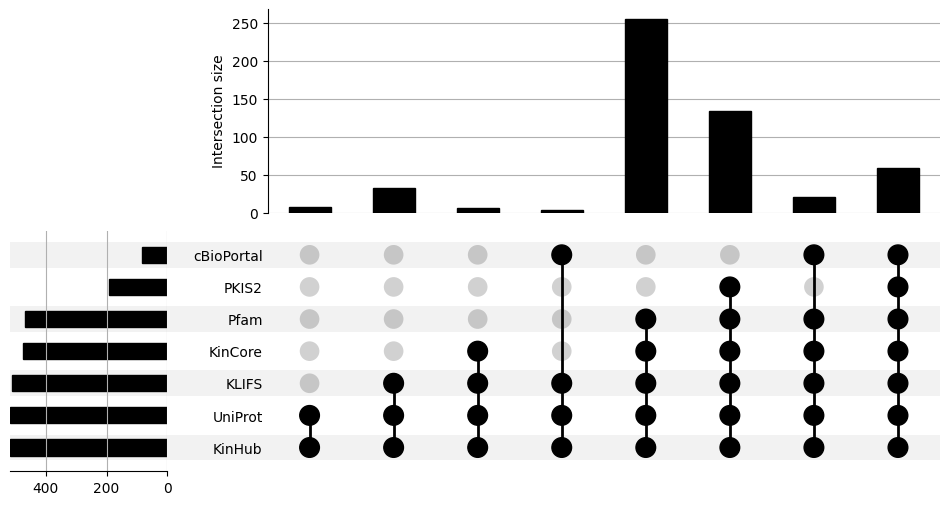

In [49]:
fig = plt.figure(figsize=(12, 6))
plot(contents, fig=fig, element_size=None)
# plt.show()
plt.savefig("upset_plot.pdf", bbox_inches='tight')

## DO NOT RUN

In [207]:
def try_except_hgnc(x):
    try:
        temp = hgnc.HGNC(x).maybe_get_info_from_hgnc_fetch(["uniprot_ids"])["uniprot_ids"][0][0]
        return temp
    except TypeError:
        return None

df_pkis_copy["hgnc_temp"] = df_pkis_copy["Assay Name"]
df_pkis_copy.loc[df_pkis_copy["hgnc_temp"].isin(list_mut), "hgnc_temp"] = df_pkis_copy.loc[df_pkis_copy["hgnc_temp"].isin(list_mut), "hgnc_temp"].apply(lambda x: x.split("-")[0])

df_pkis_copy["uniprot_hgnc"] = df_pkis_copy["hgnc_temp"].apply(lambda x: try_except_hgnc(x))

df_pkis_copy["uniprot_test"] = [df_uniprot_kinhub["uniprot_id"].iloc[idx] \
                                if idx is not np.nan else np.nan for idx in list_concat]

list_uniprot = []
for _, row in df_pkis_copy.iterrows():
    if (row["uniprot_hgnc"] is not None) & \
    (row["uniprot_hgnc"] != row["uniprot_test"]):
        print(row)
        # list_uniprot.append(row["uniprot_hgnc"])
#     else:
#         list_uniprot.append(row["uniprot_test"])

# df_pkis_copy["uniprot"] = list_uniprot

df_pkis_copy = df_pkis_copy.drop(columns = ["hgnc_temp", "uniprot_hgnc", "uniprot_test"])

Assay Name                MST1
ATP Conc.(uM)               50
ENZYME Conc.(nM)           0.4
Inc Time (hr)                3
SUPPLIER            INVITROGEN
CATALOG#                PV3854
LOT#                     38395
uniprot                 P26927
hgnc_temp                 MST1
uniprot_hgnc            P26927
uniprot_test            Q13043
Name: 131, dtype: object
Assay Name                PDK1
ATP Conc.(uM)               10
ENZYME Conc.(nM)          18.0
Inc Time (hr)                3
SUPPLIER            INVITROGEN
CATALOG#                PV4033
LOT#                    35371B
uniprot                 Q15118
hgnc_temp                 PDK1
uniprot_hgnc            Q15118
uniprot_test            O15530
Name: 157, dtype: object
Assay Name             PKD2
ATP Conc.(uM)            50
ENZYME Conc.(nM)        0.3
Inc Time (hr)             3
SUPPLIER            UPSTATE
CATALOG#             14-506
LOT#                 25273U
uniprot              Q13563
hgnc_temp              PKD2
uniprot_hgnc    

In [218]:
df_pkis_copy.loc[~df_pkis_copy["uniprot"].isin(df_uniprot_kinhub["uniprot_id"].tolist()), ]

,Assay Name,ATP Conc.(uM),ENZYME Conc.(nM),Inc Time (hr),SUPPLIER,CATALOG#,LOT#,uniprot
109,LYNB,35,0.9,3,INVITROGEN,P2907,23337,NaN


In [220]:
df_pkis_copy_no_mut = df_pkis_copy.loc[~df_pkis_copy["Assay Name"].isin(list_mut), ]
uniprot_dup = df_pkis_copy_no_mut.loc[df_pkis_copy_no_mut["uniprot"].duplicated(), "uniprot"].to_list()
df_pkis_copy_no_mut.loc[ df_pkis_copy["uniprot"].isin(uniprot_dup), ]

,Assay Name,ATP Conc.(uM),ENZYME Conc.(nM),Inc Time (hr),SUPPLIER,CATALOG#,LOT#,uniprot
30,CDK2,50,0.20,3,UPSTATE,14-448,23984,P24941
31,CDK2-CYCLINE,100,0.15,3,UPSTATE,14-475,22393U,P24941
165,PKC-BETA1,200,0.46,3,INVITROGEN,P2291,299686,P05771
170,PKCB,200,0.50,3,INVITROGEN,P2251,29433A,P05771
171,PKD2,50,0.30,3,UPSTATE,14-506,25273U,Q9BZL6
175,PRKD2,20,0.20,3,INVITROGEN,PV3758,34015,Q9BZL6
189,RSK1,20,0.75,3,INVITROGEN,PV3680,386267,Q15349
191,RSK3,50,0.40,3,UPSTATE,14-462,D7AN006BU,Q15349
208,TRKB,20,2.50,3,INVITROGEN,PV3616,35706,Q16620
209,TRKB-L,500,5.00,6,UPSTATE,14-507,1647376,Q16620


### Old mutant code

In [235]:
# find mutants
list_str_split = create_strsplit_list(df_pkis_copy["Assay Name"], idx_start=1, idx_end=1)
list_str_split = [i[0] for i in list_str_split]
# drop if list_str_split entry is strictly numeric
list_str_split = [np.nan if type(try_except_convert_str2int(i)) == int \
                  else i for i in list_str_split]
list_middle = [np.nan if i is np.nan else i[1:-1] for i in list_str_split]

df_pkis_copy["Mutant"] = False
df_pkis_copy.loc[[True if type(try_except_convert_str2int(i)) == int \
                  else False for i in list_middle], "Mutant"] = True

list_mut1 = create_strsplit_list(df_pkis_copy.loc[df_pkis_copy["Mutant"] == True, "Assay Name"], 0, 0)
list_mut2 = create_strsplit_list(df_pkis_copy.loc[df_pkis_copy["Mutant"] == True, "Assay Name"], 1, 1)
list_mut3 = create_strsplit_list(df_pkis_copy.loc[df_pkis_copy["Mutant"] == True, "Assay Name"], 2, 2)
list_muts = [y + z if x != z else y for x, y, z in zip(list_mut1, list_mut2, list_mut3)]

# have old notation of v599E instead of V600E
list_muts = [["V600E" if i == "V599E" else i for i in muts] for muts in list_muts]

dict_muts = dict(zip(df_pkis_copy.loc[df_pkis_copy["Mutant"] == True, "Assay Name"], list_muts))

for key, val in dict_muts.items():
    temp = df_pkis_copy.loc[df_pkis_copy["Assay Name"] == key, "canonical_sequence"].values[0]
    for mut in val:
        aa_wt, aa_mut, codon = mut[0], mut[-1], int(mut[1:-1])-1
        try:
            if temp[codon] == aa_wt:
                list_temp = list(temp)
                list_temp[codon] = aa_mut
                temp = "".join(list_temp)
                # print(f"{aa_wt} to {temp[codon]} at {codon} ({mut})")
            else:
                print(f"Wild-type AA at position {codon} is {temp[codon]} but expected {aa_wt} ({mut})...")
        except KeyError:
            print(f"{codon} not found in canonical {key} sequence of {len(temp)}...")
    df_pkis_copy.loc[df_pkis_copy["Assay Name"] == key, "canonical_sequence"] = temp

In [236]:
# [i.split("-")[0] for i in dict_muts.keys()]
# {i.split("-")[0]: j for i, j in dict_muts.items()}
for i, j in dict_muts.items():
    for mut in j:
        print(f"{i.split('-')[0]}-{mut}")
        start = int(df_pkis_copy.loc[df_pkis_copy["Assay Name"] == i, "start"])
        end = int(df_pkis_copy.loc[df_pkis_copy["Assay Name"] == i, "end"])
        print(f"KD: {start}:{end}")
        print(int(mut[1:-1]) >= start and int(mut[1:-1]) <= end)
        print("")

ABL1-H396P
KD: 242:492
True

ABL1-M351T
KD: 242:492
True

ABL1-Q252H
KD: 242:492
True

ABL1-T315I
KD: 242:492
True

ABL1-Y253F
KD: 242:492
True

BRAF-V600E
KD: 457:712
True

EGFR-L858R
KD: 714:966
True

EGFR-L861Q
KD: 714:966
True

EGFR-T790M
KD: 714:966
True

EGFR-T790M
KD: 714:966
True

EGFR-L858R
KD: 714:966
True

KIT-D816V
KD: 590:922
True

KIT-T6701
KD: 590:922
True

KIT-V560G
KD: 590:922
False

LRRK2-G2019S
KD: 1885:2129
True

RET-V804L
KD: 725:1005
True

RET-Y791F
KD: 725:1005
True

